<a href="https://colab.research.google.com/github/hermelawesene/AAU-Credit-Scoring-Model/blob/main/Malaria_Cell_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


In [ ]:
import pathlib
path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"
data_dir = pathlib.Path(path).with_suffix('')
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of uninfected cells", len(parasitized))

Number of uninfected cells 13780
Number of uninfected cells 13780


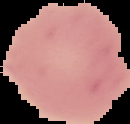

In [ ]:
import PIL
PIL.Image.open(uninfected[2])

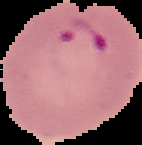

In [ ]:
PIL.Image.open(parasitized[1])

# Assign

In [ ]:
# Define paths and parameters
data_dir = pathlib.Path(path).with_suffix('')  # Update
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Data preprocessing with augmentation
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    rescale=1/255
)

In [ ]:
# Training data generator
training_data = image_gen.flow_from_directory(
    data_dir,
    subset="training",
    class_mode="binary",
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 19292 images belonging to 2 classes.


In [ ]:
# Validation data generator
validation_data = image_gen.flow_from_directory(
    data_dir,
    subset="validation",
    class_mode="binary",
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 8266 images belonging to 2 classes.


In [ ]:
# Test data generator (use half of validation data as test set)
test_data = image_gen.flow_from_directory(
    data_dir,
    subset="validation",
    class_mode="binary",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)
#test_data.samples = int(0.5 * test_data.samples)  # Use 15% of data as test set

Found 8266 images belonging to 2 classes.


In [ ]:
test_samples = int(0.5 * test_data.samples)  # ~15% of total dataset (4133 samples)
test_steps = (test_samples + batch_size - 1) // batch_size  # Ceiling division for steps
print(f"Test samples: {test_samples}, Test steps: {test_steps}")

Test samples: 4133, Test steps: 130


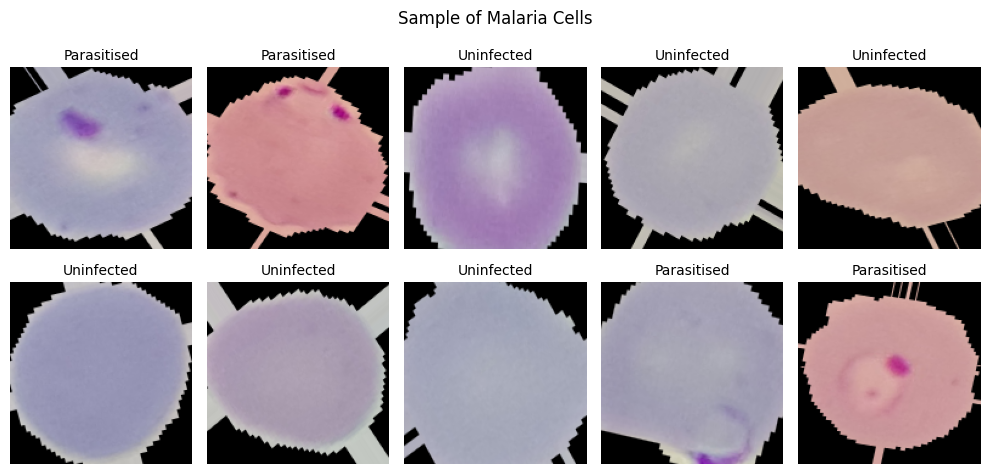

In [ ]:
import matplotlib.pyplot as plt
X_train, y_train = next(training_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i])
    ax.axis("off")
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

In [ ]:
# Define the CNN model
def create_model():
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# List of optimizers to compare
optimizers = {
    'GD': tf.keras.optimizers.SGD(learning_rate=0.01),
    'MiniBatchSGD': tf.keras.optimizers.SGD(learning_rate=0.01),
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01),
#    'GD_Repeat': tf.keras.optimizers.SGD(learning_rate=0.01),
    'Momentum': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'AdaGrad': tf.keras.optimizers.Adagrad(learning_rate=0.01),
    'RMSProp': tf.keras.optimizers.RMSprop(learning_rate=0.001),
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
}

In [ ]:
# Training parameters
epochs = 5
batch_size_dict = {
    'GD': training_data.samples,  # Full batch
    'MiniBatchSGD': batch_size,
    'SGD': 1,
    #'GD_Repeat': training_data.samples,
    'Momentum': batch_size,
    'Nesterov': batch_size,
    'AdaGrad': batch_size,
    'RMSProp': batch_size,
    'Adam': batch_size
}

In [ ]:
# Store results
results = {'Optimizer': [], 'Accuracy': [], 'F1 Score': [], 'Loss': []}
history_dict = {}

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import seaborn as sns

In [ ]:
# Train and evaluate each optimizer
import tensorflow as tf

for opt_name, optimizer in optimizers.items():
    print(f"Training with {opt_name}...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        training_data,
        epochs=epochs,
        validation_data=validation_data,
        verbose=1
    )

    # Evaluate on test set
    test_data.reset()
    y_pred = model.predict(test_data, verbose=0)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    y_test = test_data.classes[:test_data.samples]

    # Compute metrics
    acc = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    test_loss = model.evaluate(test_data, verbose=0)[0]

    # Store results
    results['Optimizer'].append(opt_name)
    results['Accuracy'].append(acc)
    results['F1 Score'].append(f1)
    results['Loss'].append(test_loss)
    history_dict[opt_name] = history.history

Training with GD...
Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.5322 - loss: 0.6895 - val_accuracy: 0.5387 - val_loss: 0.6729
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 313ms/step - accuracy: 0.6094 - loss: 0.6588 - val_accuracy: 0.6361 - val_loss: 0.6419
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 190s 315ms/step - accuracy: 0.6642 - loss: 0.6235 - val_accuracy: 0.7432 - val_loss: 0.5784
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 314ms/step - accuracy: 0.7316 - loss: 0.5547 - val_accuracy: 0.8360 - val_loss: 0.4370
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 313ms/step - accuracy: 0.8526 - loss: 0.3873 - val_accuracy: 0.8993 - val_loss: 0.2889
Training with MiniBatchSGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 218s 360ms/step - accuracy: 0.5384 - loss: 0.6868 - val_accuracy: 0.6910 - val_loss: 0.6431
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 191s 316ms/step - accuracy: 0.6232 - loss: 0.6501 - val_accuracy: 0.7005 - val_loss: 0.6254
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 190s 316ms/step - accuracy: 0.6631 - loss: 0.6228 - val_accuracy: 0.6504 - val_loss: 0.6109
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 217s 360ms/step - accuracy: 0.7069 - loss: 0.5758 - val_accuracy: 0.8456 - val_loss: 0.4580
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 193s 320ms/step - accuracy: 0.8314 - loss: 0.4300 - val_accuracy: 0.8881 - val_loss: 0.3153
Training with SGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 311ms/step - accuracy: 0.5401 - loss: 0.6882 - val_accuracy: 0.5925 - val_loss: 0.6454
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 184s 306ms/step - accuracy: 0.6124 - loss: 0.6593 - val_accuracy: 0.6976 - val_loss: 0.6156
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 187s 310ms/step - accuracy: 0.6610 - loss: 0.6232 - val_accuracy: 0.7153 - val_loss: 0.5806
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 188s 311ms/step - accuracy: 0.7085 - loss: 0.5824 - val_accuracy: 0.8039 - val_loss: 0.4626
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 188s 312ms/step - accuracy: 0.8218 - loss: 0.4404 - val_accuracy: 0.8891 - val_loss: 0.2820
Training with Momentum...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 217s 358ms/step - accuracy: 0.5358 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 187s 311ms/step - accuracy: 0.6234 - loss: 0.6461 - val_accuracy: 0.9123 - val_loss: 0.2497
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 187s 310ms/step - accuracy: 0.9056 - loss: 0.2705 - val_accuracy: 0.9248 - val_loss: 0.2236
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 187s 310ms/step - accuracy: 0.9304 - loss: 0.2191 - val_accuracy: 0.9131 - val_loss: 0.2421
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 187s 310ms/step - accuracy: 0.9339 - loss: 0.2032 - val_accuracy: 0.9349 - val_loss: 0.2036
Training with Nesterov...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 191s 314ms/step - accuracy: 0.5946 - loss: 0.6556 - val_accuracy: 0.9108 - val_loss: 0.2525
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 187s 310ms/step - accuracy: 0.9059 - loss: 0.2716 - val_accuracy: 0.9301 - val_loss: 0.2200
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 314ms/step - accuracy: 0.9204 - loss: 0.2386 - val_accuracy: 0.9312 - val_loss: 0.2114
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 220s 365ms/step - accuracy: 0.9313 - loss: 0.2207 - val_accuracy: 0.9358 - val_loss: 0.1826
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 193s 321ms/step - accuracy: 0.9306 - loss: 0.2169 - val_accuracy: 0.9297 - val_loss: 0.1816
Training with AdaGrad...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.5204 - loss: 0.6906 - val_accuracy: 0.7045 - val_loss: 0.6099
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 193s 320ms/step - accuracy: 0.6392 - loss: 0.6391 - val_accuracy: 0.7593 - val_loss: 0.5511
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 188s 313ms/step - accuracy: 0.7461 - loss: 0.5339 - val_accuracy: 0.8686 - val_loss: 0.3825
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 188s 312ms/step - accuracy: 0.8748 - loss: 0.3335 - val_accuracy: 0.9047 - val_loss: 0.2571
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 216s 358ms/step - accuracy: 0.9075 - loss: 0.2575 - val_accuracy: 0.9129 - val_loss: 0.2241
Training with RMSProp...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 192s 315ms/step - accuracy: 0.6913 - loss: 0.6323 - val_accuracy: 0.8605 - val_loss: 0.3733
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 313ms/step - accuracy: 0.9180 - loss: 0.2452 - val_accuracy: 0.9123 - val_loss: 0.2765
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 314ms/step - accuracy: 0.9312 - loss: 0.2279 - val_accuracy: 0.9339 - val_loss: 0.1931
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 193s 321ms/step - accuracy: 0.9317 - loss: 0.2220 - val_accuracy: 0.9425 - val_loss: 0.2209
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 194s 322ms/step - accuracy: 0.9387 - loss: 0.2134 - val_accuracy: 0.9191 - val_loss: 0.2253
Training with Adam...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 199s 326ms/step - accuracy: 0.6072 - loss: 0.7486 - val_accuracy: 0.8853 - val_loss: 0.3496
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 190s 315ms/step - accuracy: 0.8916 - loss: 0.2935 - val_accuracy: 0.9107 - val_loss: 0.2140
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 190s 315ms/step - accuracy: 0.9175 - loss: 0.2290 - val_accuracy: 0.9295 - val_loss: 0.1950
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 189s 313ms/step - accuracy: 0.9293 - loss: 0.2117 - val_accuracy: 0.9177 - val_loss: 0.1983
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 191s 317ms/step - accuracy: 0.9320 - loss: 0.2066 - val_accuracy: 0.9239 - val_loss: 0.1980


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting training curves
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

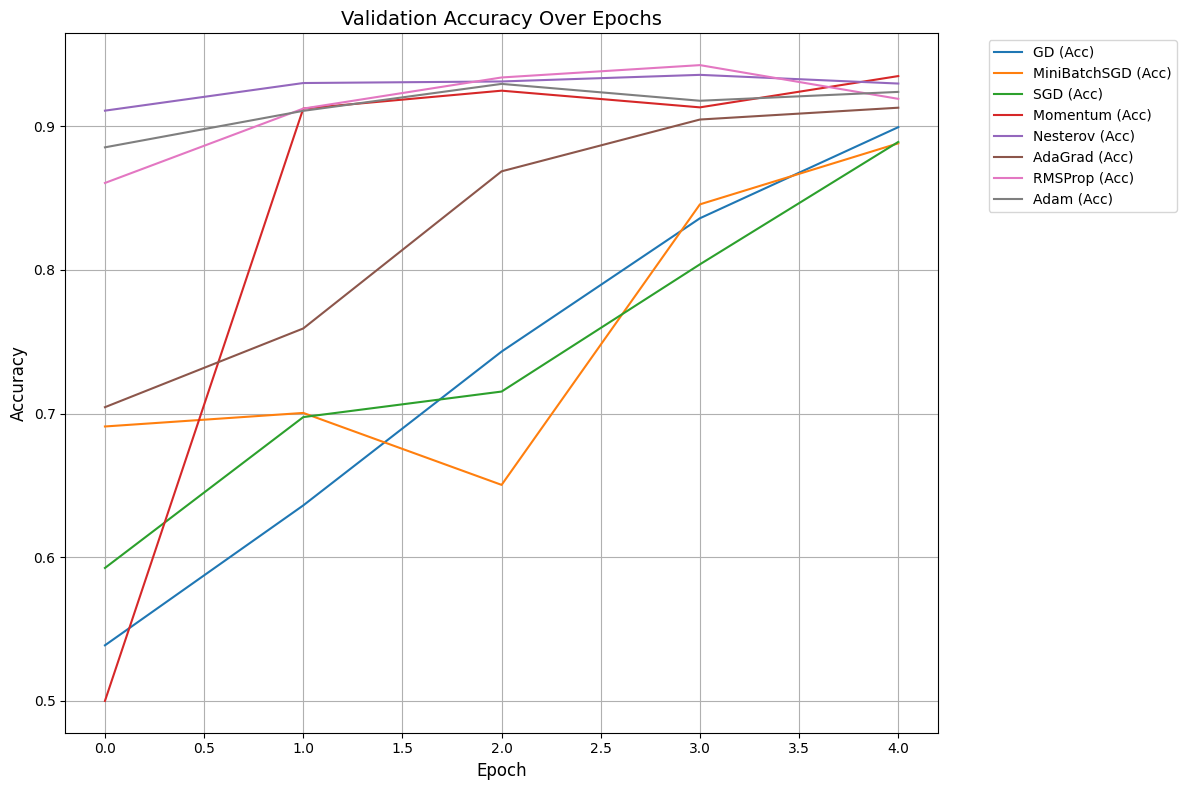

In [ ]:
# Accuracy curves
# Overall validation accuracy plot (fixed)
plt.figure(figsize=(12, 8))  # Larger figure size
for opt_name in optimizers.keys():
    plt.plot(history_dict[opt_name]['val_accuracy'], label=f'{opt_name} (Acc)')
plt.title('Validation Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)  # Legend outside
plt.tight_layout()  # Adjust layout
plt.show()

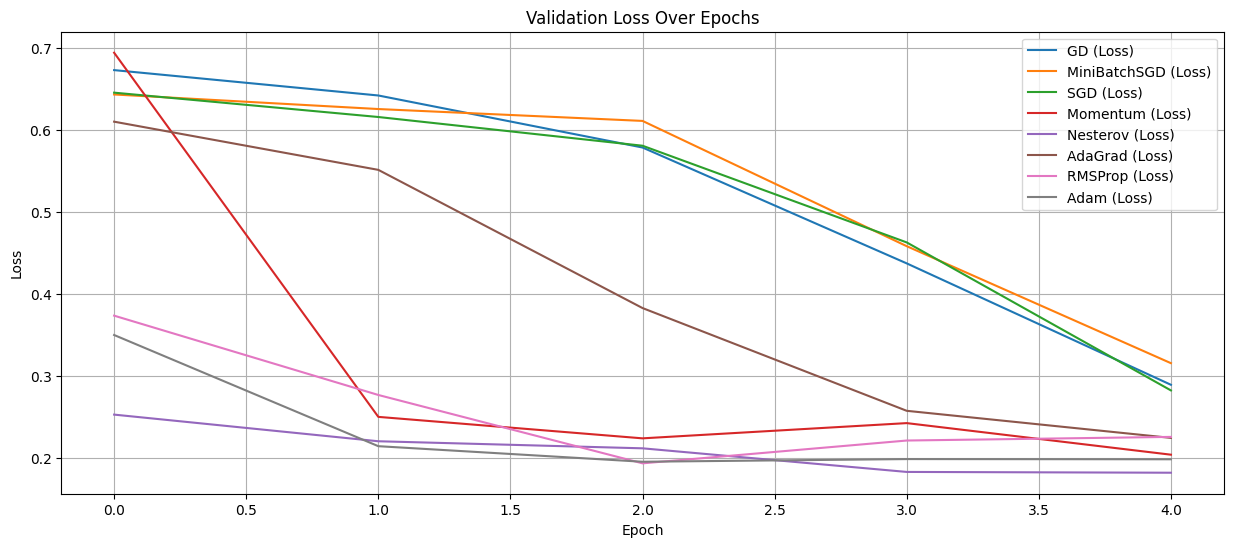

In [ ]:
# Loss curves
plt.figure(figsize=(15, 6))
for opt_name in optimizers.keys():
    plt.plot(history_dict[opt_name]['val_loss'], label=f'{opt_name} (Loss)')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

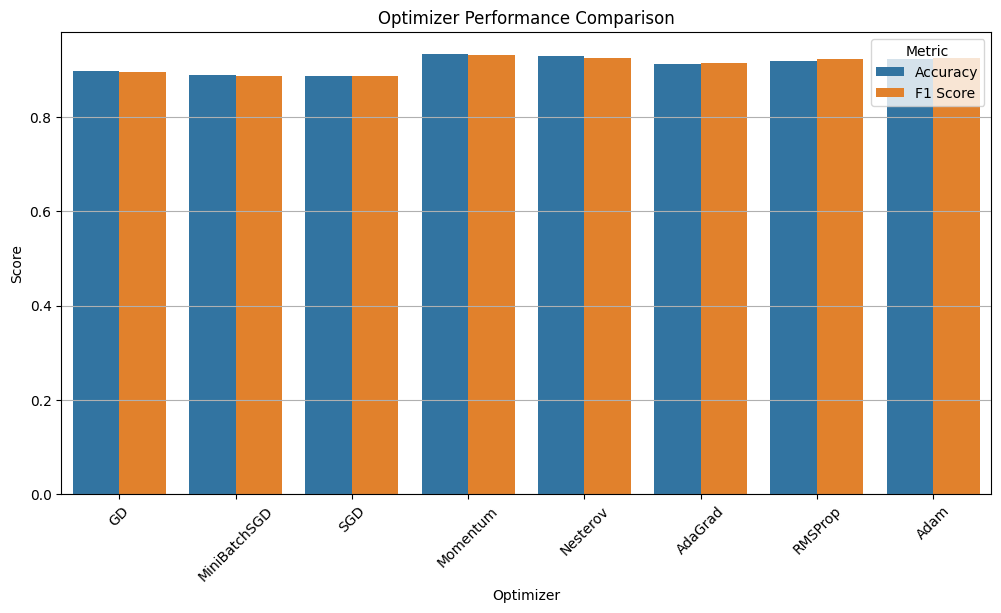

In [ ]:
# Bar plot for Accuracy and F1 Score
plt.figure(figsize=(12, 6))
results_df_melted = pd.melt(
    results_df,
    id_vars=['Optimizer'],
    value_vars=['Accuracy', 'F1 Score'],
    var_name='Metric',
    value_name='Score'
)
sns.barplot(x='Optimizer', y='Score', hue='Metric', data=results_df_melted)
plt.title('Optimizer Performance Comparison')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

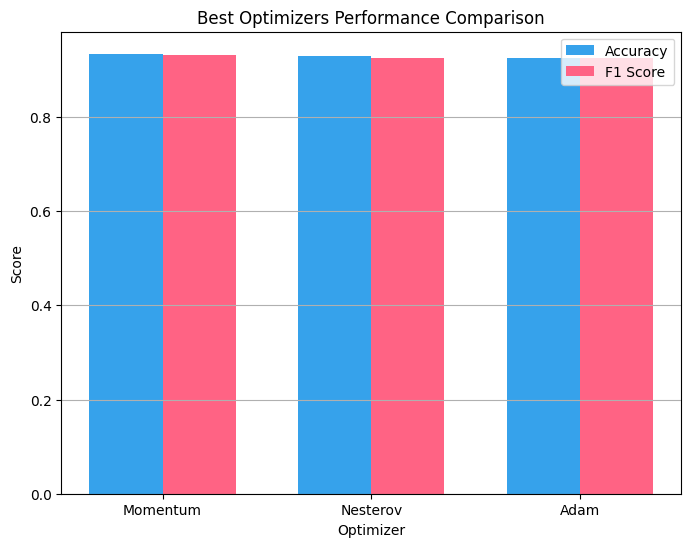

In [ ]:
# Bar plot for best optimizers
import numpy as np
best_optimizers = ['Momentum', 'Nesterov', 'Adam']  # Adjust based on actual results
best_results = results_df[results_df['Optimizer'].isin(best_optimizers)]
plt.figure(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(best_results))
# Changed color format to a valid hexadecimal string
plt.bar(index, best_results['Accuracy'], bar_width, label='Accuracy', color='#36A2EB') # Using a valid hex color
# Changed color format to a valid hexadecimal string
plt.bar(index + bar_width, best_results['F1 Score'], bar_width, label='F1 Score', color='#FF6384') # Using a valid hex color
plt.xlabel('Optimizer')
plt.ylabel('Score')
plt.title('Best Optimizers Performance Comparison')
plt.xticks(index + bar_width / 2, best_results['Optimizer'])
plt.legend()
plt.grid(True, axis='y')
plt.show()

In [ ]:
# Rank optimizers based on F1 Score
results_df['Rank'] = results_df['F1 Score'].rank(ascending=False).astype(int)
results_df = results_df.sort_values('Rank')
print("\nOptimizer Ranking:")
print(results_df[['Optimizer', 'Accuracy', 'F1 Score', 'Rank']])


Optimizer Ranking:
      Optimizer  Accuracy  F1 Score  Rank
3      Momentum  0.934430  0.932486     1
4      Nesterov  0.929591  0.926161     2
7          Adam  0.924510  0.925750     3
6       RMSProp  0.918703  0.923480     4
5       AdaGrad  0.913743  0.914723     5
0            GD  0.897411  0.894972     6
1  MiniBatchSGD  0.889669  0.887519     7
2           SGD  0.888217  0.886486     8


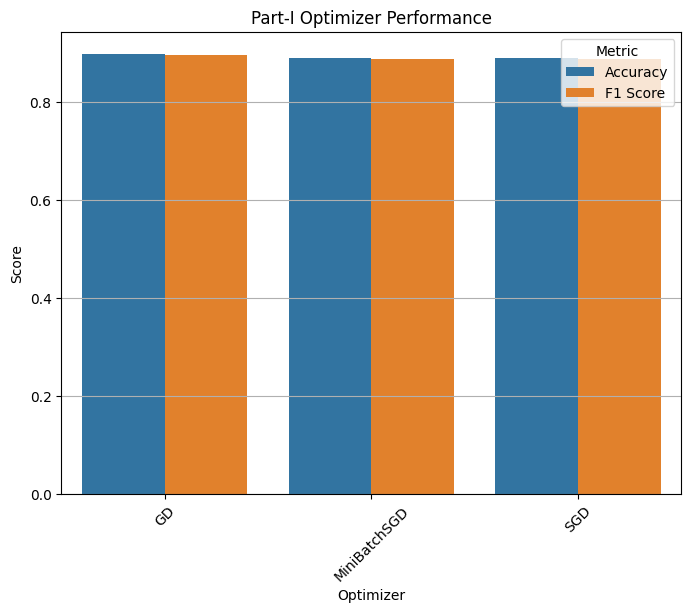

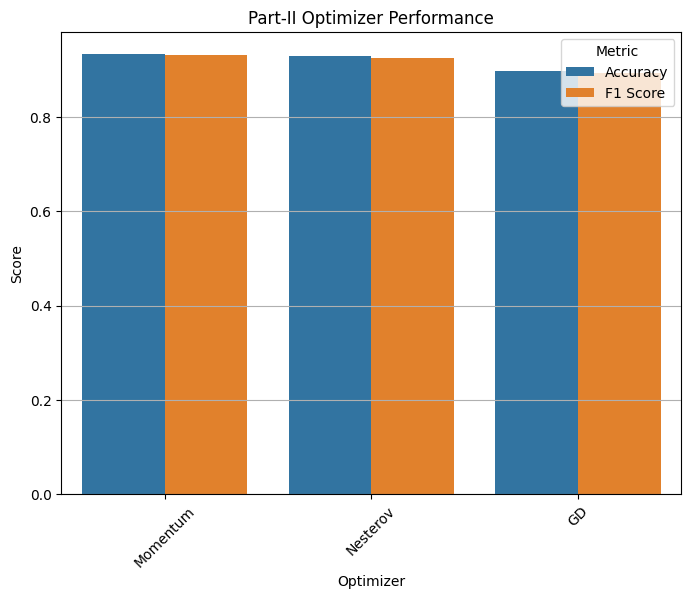

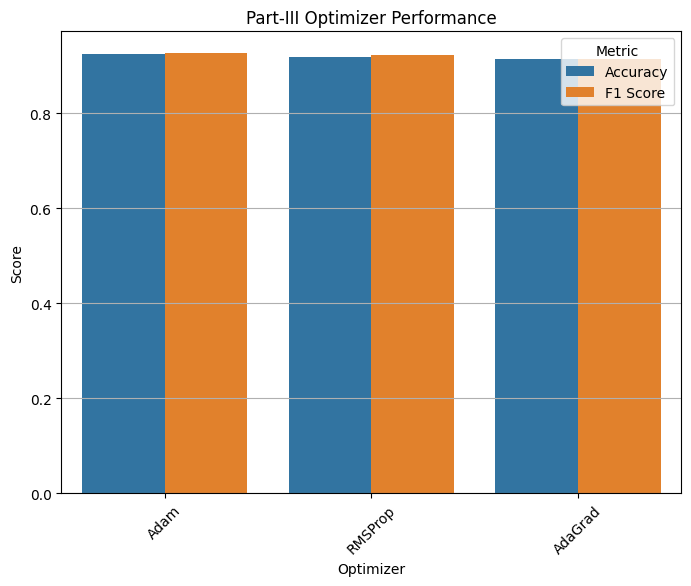

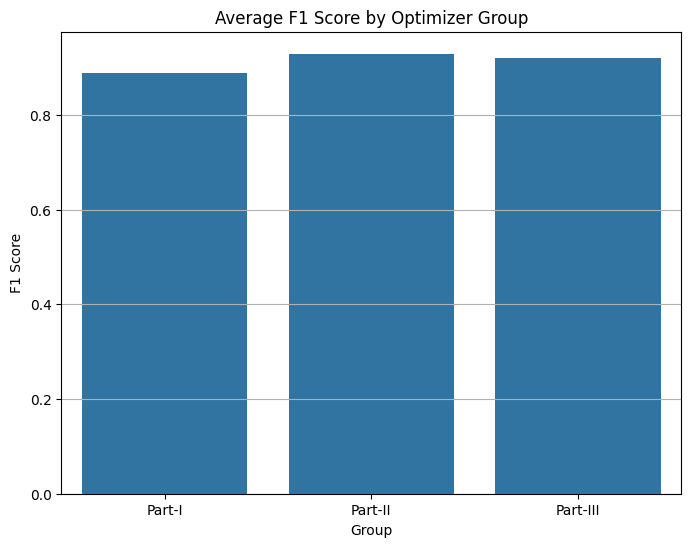


Optimizer Performance by Group:

Part-I:
      Optimizer  Accuracy  F1 Score      Loss
0            GD  0.897411  0.894972  0.292836
1  MiniBatchSGD  0.889669  0.887519  0.310787
2           SGD  0.888217  0.886486  0.283084

Part-II:
  Optimizer  Accuracy  F1 Score      Loss
3  Momentum  0.934430  0.932486  0.203478
4  Nesterov  0.929591  0.926161  0.180546

Part-III:
  Optimizer  Accuracy  F1 Score      Loss
7      Adam  0.924510  0.925750  0.195668
6   RMSProp  0.918703  0.923480  0.228958
5   AdaGrad  0.913743  0.914723  0.228017


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume results_df exists (from optimizer_results.csv or model training)
# Example structure: Optimizer, Accuracy, F1 Score, Loss
# Load results_df if needed: results_df = pd.read_csv('optimizer_results.csv')

# Group definitions
groups = {
    'Part-I': ['GD', 'MiniBatchSGD', 'SGD'],
    'Part-II': ['GD', 'Momentum', 'Nesterov'],
    'Part-III': ['AdaGrad', 'RMSProp', 'Adam']
}

# Add Group column to results_df if not present
if 'Group' not in results_df.columns:
    results_df['Group'] = results_df['Optimizer'].apply(
        lambda x: next(g for g, opts in groups.items() if x in opts)
    )

# Group-specific bar plots
for group_name, group_opts in groups.items():
    group_df = results_df[results_df['Optimizer'].isin(group_opts)]
    plt.figure(figsize=(8, 6))
    group_melted = pd.melt(
        group_df,
        id_vars=['Optimizer'],
        value_vars=['Accuracy', 'F1 Score'],
        var_name='Metric',
        value_name='Score'
    )
    sns.barplot(x='Optimizer', y='Score', hue='Metric', data=group_melted)
    plt.title(f'{group_name} Optimizer Performance')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

# Group-averaged F1 Score bar plot
group_means = results_df.groupby('Group')['F1 Score'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Group', y='F1 Score', data=group_means)
plt.title('Average F1 Score by Optimizer Group')
plt.grid(True, axis='y')
plt.show()

# Print group-wise table
print("\nOptimizer Performance by Group:")
for group_name in groups.keys():
    print(f"\n{group_name}:")
    group_df = results_df[results_df['Group'] == group_name][['Optimizer', 'Accuracy', 'F1 Score', 'Loss']]
    print(group_df)

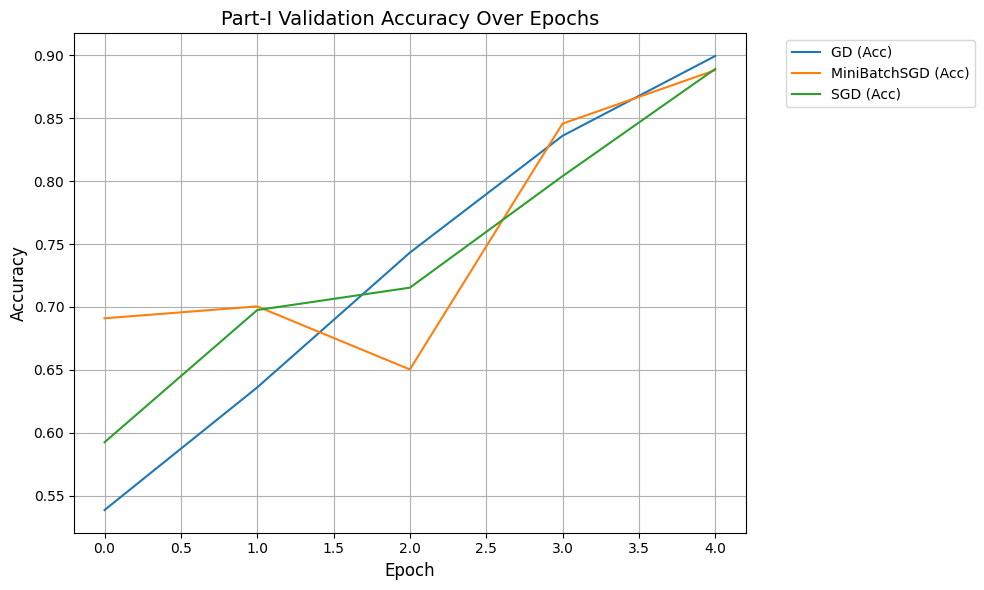

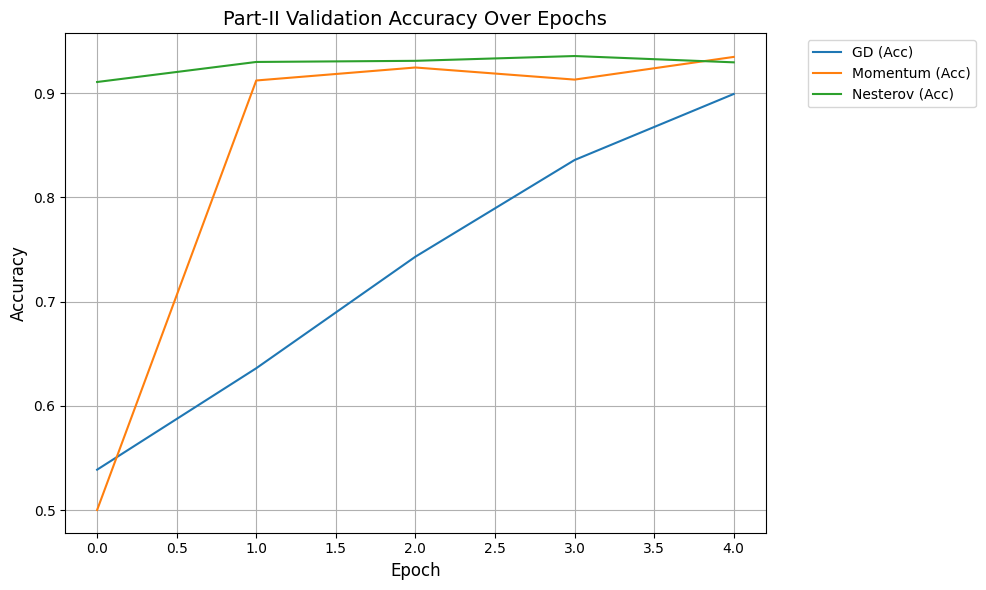

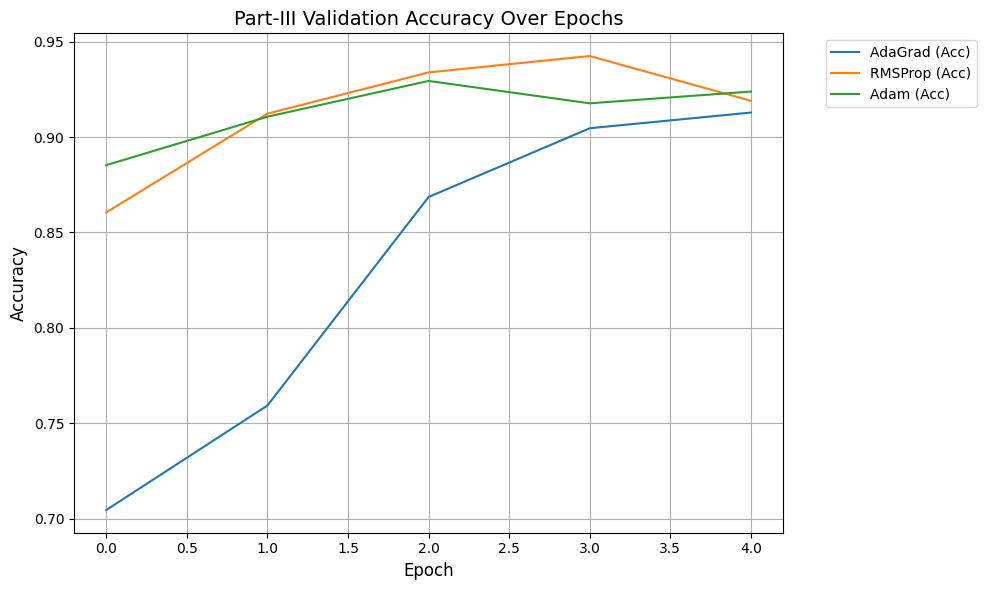

In [ ]:
# Group-specific validation accuracy plots
for group_name, group_opts in groups.items():
    plt.figure(figsize=(10, 6))  # Slightly smaller for group plots
    for opt_name in group_opts:
        if opt_name in history_dict:  # Ensure optimizer exists
            plt.plot(history_dict[opt_name]['val_accuracy'], label=f'{opt_name} (Acc)')
    plt.title(f'{group_name} Validation Accuracy Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()